In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.image import central_crop, pad_to_bounding_box, resize
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.4 
session = tf.compat.v1.Session(config=config)

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4103154287437103842
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1073741824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6933951164699662383
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [7]:
df = pd.read_excel('data_file/여행지 라벨.xlsx')
df

,나라,관광지,en나라,en관광지,유형,Unnamed: 5
0,미국,그리피스 천문대,America,Griffith Observatory,건축물,NaN
1,미국,자유의 여신상,America,Statue of Liberty,조형물,NaN
2,호주,시드니 오페라 하우스,Australia,Sydney Opera House,건축물,랜드마크
3,브라질,브라질 예수상,Brazil,Corcovado,조형물,랜드마크
4,브라질,셀라론 계단,Brazil,Escadaria Selaron,조형물,랜드마크
...,...,...,...,...,...,...
75,태국,에메랄드 사원,Thailand,Wat Phra Kaew,유적,성지
76,터키,술탄 아흐메트 모스크,Turkey,Blue Mosque,건축물,성지
77,터키,예레바탄 지하궁전,Turkey,Basilica Cistern,유적,역사유적
78,터키,하드리아누스의 문,Turkey,Hadrian's Gate,유적,고대유적


In [41]:
train_datagen = ImageDataGenerator(rescale=0./255)
validataion_datagen = ImageDataGenerator(rescale=0./255)
test_datagen = ImageDataGenerator(rescale=0./255)

In [47]:
classes_li = list(df['en관광지'][:10].values)
target_size = (360, 360)
batch_size = 20
train_generator = train_datagen.flow_from_directory('img_gen/prepro_train', target_size = target_size, batch_size = batch_size, classes=classes_li, shuffle=True)
validataion_generator = validataion_datagen.flow_from_directory('img_gen/validataion', target_size = target_size, batch_size = batch_size, classes=classes_li)
test_generator = test_datagen.flow_from_directory('img_gen/test', target_size = target_size, batch_size = batch_size, classes=classes_li)

Found 1005 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Found 2433 images belonging to 10 classes.


In [ ]:
for x_data, y_data in train_generator:
    print(x_data.shape)  # (20, 150, 150, 3)
    print(type(x_data))  # <class 'numpy.ndarray'>
    print(y_data)
    break

In [ ]:
fig, axes = plt.subplot(10,2, figsize=(10,10))
for i in range(20):
    fig.imshow(x_data[i]/255)

In [56]:
df[['en나라', 'en관광지']][-1:].values

array([['United Arab Emirates', 'Burj Khalifa']], dtype=object)

In [9]:
tour_name = 'Burj Khalifa'
path = f"img/United Arab Emirates/{tour_name}/"
names = os.listdir(path)

for i, name in enumerate(names):
    old_name = path + name
    new_name = path + tour_name + str(i) + ".jpg"
    #print(old_name, new_name)
    os.rename(old_name, new_name)
    
names = os.listdir(path)    
for i, name in enumerate(names):
    old_name = path + name
    new_name = path + str(i) + ".jpg"
    #print(old_name, new_name)
    os.rename(old_name, new_name)

In [92]:
df[df['en관광지'] == 'Penang temple']

,나라,관광지,en나라,en관광지,유형,Unnamed: 5
55,말레이시아,쿠 콩시,Malaysia,Penang temple,건축물,NaN


In [19]:
x = []
y = []
size = (256, 256)
datas = df[['en나라', 'en관광지']].values
for data in datas:
    country = data[0]
    tour = data[1]
    for i in range(100):
        path = f"img/{country}/{tour}/{i}.jpg"
        img = load_img(path)
        img_array = img_to_array(img) / 255
        img_resize = resize(img_array, size)
        x.append(np.array(img_resize))
        y.append(tour)
    print(f"{tour} transform Successful")
x = np.array(x)

Griffith Observatory transform Successful
Statue of Liberty transform Successful
Sydney Opera House transform Successful
Corcovado transform Successful
Escadaria Selaron transform Successful
Angkor Wat transform Successful
Easter Island transform Successful
Canton Tower transform Successful
qin terracotta warriors transform Successful
The Great Wall transform Successful
Forbidden City transform Successful
Potala Palace transform Successful
Staromestske namesti transform Successful
Temple of Karnak transform Successful
Colossi of Memnon transform Successful
Egypt Pyramid transform Successful
abu simbel transform Successful
Stonehenge transform Successful
Tower Bridge transform Successful
St. Paul's Cathedral transform Successful
Louvre Museum transform Successful
Eiffel Tower transform Successful
Cathedrale Notre-Dame de Paris transform Successful
Arc de Triomphe transform Successful
Sainte-Chapelle transform Successful
Moulin Rouge transform Successful
Hotel de Ville transform Successf

In [94]:
x

[]

In [63]:
x_train = []
y_train = []
tour = 'Burj Khalifa1'
size = (360, 360)
for i in range(100):
    path = f"img/United Arab Emirates/{tour}/{i}.jpg"
    img = load_img(path)
    img_array = img_to_array(img) / 255
    img_resize = resize(img_array, size)
    x_train.append(np.array(img_resize))
    y_train.append(tour)
print(f"{tour} transform Successful")

Burj Khalifa1 transform Successful


In [13]:
x_test = []
y_test = []
tour = 'Burj Khalifa'
size = (360, 360)
for i in range(2000):
    path = f"img/United Arab Emirates/{tour}/{i}.jpg"
    img = load_img(path)
    img_array = img_to_array(img) / 255
    img_resize = resize(img_array, size)
    x_test.append(np.array(img_resize))
    y_test.append(tour)
print(f"{tour} transform Successful")

Burj Khalifa transform Successful


In [14]:
np.array(y_test).shape

(2000,)

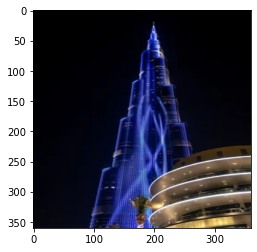

In [19]:
plt.imshow(x_train[0])

In [13]:
y_test

['Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa',
 'Burj Khalifa

In [85]:
x_split = x[:500]
y_split = y[:500]

In [20]:
# x_train, x_test, y_train, y_test = train_test_split(x_split, y_split, test_size=0.2, random_state=111)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=111)

In [21]:
en = LabelEncoder()
y_train_en = en.fit_transform(y_train)
y_test_en = en.fit_transform(y_test)

In [22]:
y_train_oh = to_categorical(y_train_en)
y_test_oh = to_categorical(y_test_en)

In [23]:
y_test_oh.shape

(4000, 80)

In [48]:
with tf.device('/GPU:0'):
    model = Sequential()
    model.add(Conv2D(8, (3,3), strides=1, activation='relu', padding='same', input_shape=(360, 360, 3)))
    model.add(MaxPooling2D(2))
    model.add(Dropout(0.2))

    model.add(Conv2D(16, (3,3), strides=1, activation='relu', padding='same'))
    model.add(MaxPooling2D(2))
    model.add(Dropout(0.2))

    model.add(Flatten())
    
#     model.add(Dense(512, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 360, 360, 8)       224       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 180, 180, 8)      0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 180, 180, 8)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      1168      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 90, 90, 16)       

In [49]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [50]:
# with tf.device('/GPU:0'):
#     hist = model.fit(x_train, y_train_oh, batch_size=10, epochs=50, validation_data=(x_test, y_test_oh))

In [51]:
with tf.device('/GPU:0'):
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=20,
        epochs=200,
        validation_data=validataion_generator,
        validation_steps=10,
)

C:\Users\bitcamp\AppData\Local\Temp/ipykernel_11736/1770143513.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/200
20/20 [==============================] - 5s 246ms/step - loss: 5119.2969 - accuracy: 0.1117 - val_loss: 451.1138 - val_accuracy: 0.1500
Epoch 2/200
20/20 [==============================] - 4s 211ms/step - loss: 434.9006 - accuracy: 0.1429 - val_loss: 9.4740 - val_accuracy: 0.1050
Epoch 3/200
20/20 [==============================] - 4s 196ms/step - loss: 6.6751 - accuracy: 0.1450 - val_loss: 3.8730 - val_accuracy: 0.1650
Epoch 4/200
20/20 [==============================] - 4s 176ms/step - loss: 2.3027 - accuracy: 0.1075 - val_loss: 3.0502 - val_accuracy: 0.1350
Epoch 5/200
20/20 [==============================] - 3s 162ms/step - loss: 2.2941 - accuracy: 0.1013 - val_loss: 2.5639 - val_accuracy: 0.1650
Epoch 6/200
20/20 [==============================] - 3s 170ms/step - loss: 2.3841 - accuracy: 0.1225 - val_loss: 2.3134 - val_accuracy: 0.1450
Epoch 7/200
20/20 [==============================] - 3s 164ms/step - loss: 2.2919 - accuracy: 0.1225 - val_loss: 2.3942 - val_accuracy:

Epoch 58/200
20/20 [==============================] - 3s 158ms/step - loss: 1.9163 - accuracy: 0.3117 - val_loss: 2.3698 - val_accuracy: 0.1150
Epoch 59/200
20/20 [==============================] - 3s 154ms/step - loss: 1.7775 - accuracy: 0.3325 - val_loss: 2.3129 - val_accuracy: 0.1300
Epoch 60/200
20/20 [==============================] - 3s 151ms/step - loss: 1.8722 - accuracy: 0.2831 - val_loss: 2.5399 - val_accuracy: 0.1150
Epoch 61/200
20/20 [==============================] - 3s 158ms/step - loss: 1.8535 - accuracy: 0.3075 - val_loss: 2.2584 - val_accuracy: 0.1450
Epoch 62/200
20/20 [==============================] - 3s 157ms/step - loss: 1.7629 - accuracy: 0.3429 - val_loss: 2.3807 - val_accuracy: 0.0900
Epoch 63/200
20/20 [==============================] - 3s 156ms/step - loss: 1.8643 - accuracy: 0.3195 - val_loss: 2.4318 - val_accuracy: 0.1250
Epoch 64/200
20/20 [==============================] - 3s 155ms/step - loss: 1.8134 - accuracy: 0.3636 - val_loss: 2.5199 - val_accuracy:

Epoch 115/200
20/20 [==============================] - 3s 153ms/step - loss: 1.0582 - accuracy: 0.5870 - val_loss: 3.7070 - val_accuracy: 0.1550
Epoch 116/200
20/20 [==============================] - 3s 158ms/step - loss: 1.2455 - accuracy: 0.5000 - val_loss: 3.3056 - val_accuracy: 0.1550
Epoch 117/200
20/20 [==============================] - 3s 156ms/step - loss: 1.1621 - accuracy: 0.5636 - val_loss: 2.8785 - val_accuracy: 0.1300
Epoch 118/200
20/20 [==============================] - 3s 158ms/step - loss: 1.1712 - accuracy: 0.5350 - val_loss: 2.9692 - val_accuracy: 0.1750
Epoch 119/200
20/20 [==============================] - 3s 159ms/step - loss: 1.1528 - accuracy: 0.5750 - val_loss: 3.6564 - val_accuracy: 0.1700
Epoch 120/200
20/20 [==============================] - 3s 158ms/step - loss: 1.0792 - accuracy: 0.5925 - val_loss: 2.9544 - val_accuracy: 0.1650
Epoch 121/200
20/20 [==============================] - 3s 159ms/step - loss: 1.1970 - accuracy: 0.5175 - val_loss: 3.3696 - val_ac

20/20 [==============================] - 3s 155ms/step - loss: 0.8798 - accuracy: 0.6597 - val_loss: 4.2144 - val_accuracy: 0.2200
Epoch 172/200
20/20 [==============================] - 3s 162ms/step - loss: 0.8911 - accuracy: 0.6825 - val_loss: 4.5751 - val_accuracy: 0.2300
Epoch 173/200
20/20 [==============================] - 3s 158ms/step - loss: 0.7632 - accuracy: 0.7300 - val_loss: 3.9944 - val_accuracy: 0.2350
Epoch 174/200
20/20 [==============================] - 3s 160ms/step - loss: 0.7958 - accuracy: 0.7175 - val_loss: 5.3170 - val_accuracy: 0.2400
Epoch 175/200
20/20 [==============================] - 3s 154ms/step - loss: 0.8014 - accuracy: 0.6961 - val_loss: 6.7744 - val_accuracy: 0.2100
Epoch 176/200
20/20 [==============================] - 3s 155ms/step - loss: 0.8071 - accuracy: 0.7150 - val_loss: 4.9952 - val_accuracy: 0.2100
Epoch 177/200
20/20 [==============================] - 3s 155ms/step - loss: 0.8091 - accuracy: 0.7273 - val_loss: 4.8783 - val_accuracy: 0.1350

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

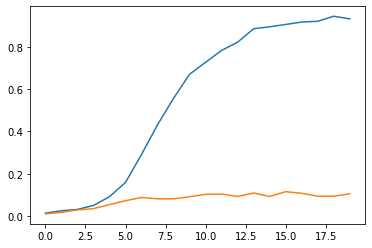

In [17]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

In [18]:
model.evaluate(x_test, y_test_oh)

25/25 [==============================] - 0s 3ms/step - loss: 7.8184 - accuracy: 0.1050


[7.818350791931152, 0.10499999672174454]

In [19]:
pred = model.predict(x_test)

In [20]:
for i in range(len(pred)):
    print(np.argmax(pred[i]) == y_test_en[i])

False
False
False
True
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
True
False
True
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
True
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
False
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
F

In [39]:
pre_model = VGG19(weights='imagenet', include_top=False, input_shape=(360, 360, 3), classes=30)

In [48]:
x = pre_model.output
x = Flatten()(x)
predictions = Dense(30, activation='softmax')(x)

In [55]:
model = Model(inputs=pre_model.input, outputs=predictions)

In [56]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 360, 360, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 360, 360, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 360, 360, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 180, 180, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 180, 180, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 180, 180, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 90, 90, 128)       0     

In [57]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [59]:
with tf.device('/GPU:0'):
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=20,
        epochs=200,
        validation_data=validataion_generator,
        validation_steps=10,
)

Epoch 1/200


C:\Users\bitcamp\AppData\Local\Temp/ipykernel_3628/1770143513.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


20/20 [==============================] - 17s 662ms/step - loss: 14.7456 - accuracy: 0.0250 - val_loss: 3.4014 - val_accuracy: 0.0300
Epoch 2/200
20/20 [==============================] - 13s 645ms/step - loss: 3.4222 - accuracy: 0.0325 - val_loss: 3.4023 - val_accuracy: 0.0200
Epoch 3/200
20/20 [==============================] - 13s 647ms/step - loss: 3.4022 - accuracy: 0.0400 - val_loss: 3.4006 - val_accuracy: 0.0250
Epoch 4/200
20/20 [==============================] - 13s 649ms/step - loss: 3.4004 - accuracy: 0.0325 - val_loss: 3.4033 - val_accuracy: 0.0400
Epoch 5/200
20/20 [==============================] - 13s 650ms/step - loss: 3.4012 - accuracy: 0.0325 - val_loss: 3.4014 - val_accuracy: 0.0250
Epoch 6/200
20/20 [==============================] - 13s 656ms/step - loss: 3.4016 - accuracy: 0.0350 - val_loss: 3.4017 - val_accuracy: 0.0250
Epoch 7/200
20/20 [==============================] - 13s 655ms/step - loss: 3.4019 - accuracy: 0.0325 - val_loss: 3.4022 - val_accuracy: 0.0300
Epo

20/20 [==============================] - 13s 675ms/step - loss: 3.4002 - accuracy: 0.0375 - val_loss: 3.4012 - val_accuracy: 0.0200
Epoch 114/200
20/20 [==============================] - 14s 676ms/step - loss: 3.4026 - accuracy: 0.0475 - val_loss: 3.4005 - val_accuracy: 0.0450
Epoch 115/200
20/20 [==============================] - 14s 676ms/step - loss: 3.4004 - accuracy: 0.0325 - val_loss: 3.4000 - val_accuracy: 0.0400
Epoch 116/200
20/20 [==============================] - 13s 675ms/step - loss: 3.4009 - accuracy: 0.0375 - val_loss: 3.4048 - val_accuracy: 0.0100
Epoch 117/200
20/20 [==============================] - 14s 675ms/step - loss: 3.4018 - accuracy: 0.0250 - val_loss: 3.4006 - val_accuracy: 0.0500
Epoch 118/200
20/20 [==============================] - 14s 676ms/step - loss: 3.4025 - accuracy: 0.0325 - val_loss: 3.4013 - val_accuracy: 0.0400
Epoch 119/200
20/20 [==============================] - 13s 675ms/step - loss: 3.3996 - accuracy: 0.0350 - val_loss: 3.4013 - val_accuracy: